In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.integrate import quad
import sympy as sp; sp.init_printing()
from wheeler import wheeler

## Rolsin Rammler Fit

* Find the Roslin Rammler distribution for an experimental cumulative size distribution.
    * Given the particle sizes (diameters) and the cumulative distribution fractions.
    * Fit the data to find the R-R parameters 
* Given the R-R distribution, select a desired number N of particle sizes to consider.
    * Compute 2N moments of the distribution and invert these moments to find corresponding quadrature weights and abscissas.
        * The abscissas are the particle diamters.
        * The weights are the number of particles.
    * Scale the weights by a constant factor so that the total particle mass is some desired value: mcoal.

101.0 101.0


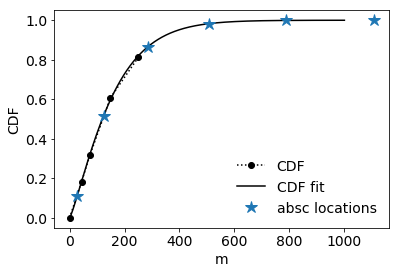

In [19]:
m  = np.array([0, 44, 74, 149, 250])                  # SPECIFY: particle masses (kg/part)
c  = np.array([0, 0.1838, 0.31717, 0.60845, 0.81193]) # SPECIFY: particle numbers (#/m3)
mcoal = 101.0                                         # SPECIFY: desired total coal (kg/m3)
rhoc  = 2000                                          # SPECIFY: coal particle density (kg/m3)

#----------------------- fit CDF(m) to RR distribution
# RR = RR(m) with mp and n as fitted parameters

def RR_cdf(m, mp, n):
    return 1 - np.exp(-(m/mp)**n)
def RR_pdf(m, mp, n):
    return n*(m/mp)**n/m*np.exp(-(m/mp)**n)

mp_n, _ = curve_fit(RR_cdf, m, c, p0=(np.average(m), 1))      # fit to the CDF
mp = mp_n[0]
n  = mp_n[1]

m_lots = np.linspace(0.01,np.max(m)*4,1000)   # x-axis for plotting 
c_fit = RR_cdf(m_lots, mp, n)                 # 


#------------------------
# compute moments to find corresponding weights and abscissas
# invert the moments to get weights, abscissas
# use the wheeler algorithm
# The number of weights and abscissas = n_moments/2

Nsizes = 6
Nmom = Nsizes*2

Mom = np.empty(Nmom)
for k in range(Nmom):
    Mom[k] = quad( lambda x: RR_pdf(x, mp, n)*x**k, 0, np.max(m)*5 )[0]

wts, absc = wheeler(Mom)

#----------------------- plot results

plt.rc('font', size=14)
plt.plot(m,      c,     'ko:')
plt.plot(m_lots, c_fit, 'k-') 
plt.plot(absc, RR_cdf(absc, mp, n), '*', markersize=12)
plt.legend(['CDF', 'CDF fit', 'absc locations'], frameon=False)
plt.xlabel('m')
plt.ylabel('CDF');

#----------------------- scale the wts for desired mcoal
# assume absc are particle diameters

M = np.pi/6*absc**3*rhoc
wts = wts*mcoal/np.sum(wts*M)

print(mcoal, np.sum(wts*M))

